In [31]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomResizedCrop

In [32]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform_gray=None, transform_color=None):
        """
        Args:
            root_dir (str): Directory containing 'gray' and 'color' subfolders.
            transform_gray (callable, optional): Transform to apply to grayscale images.
            transform_color (callable, optional): Transform to apply to color images.
        """
        self.gray_dir = os.path.join(root_dir, "gray")
        self.color_dir = os.path.join(root_dir, "color")
        
        # Load file names and ensure both have matching pairs
        self.gray_images = sorted(os.listdir(self.gray_dir))
        self.color_images = sorted(os.listdir(self.color_dir))
        assert len(self.gray_images) == len(self.color_images), "Mismatch in dataset sizes!"
        
        self.transform_gray = transform_gray
        self.transform_color = transform_color

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, idx):
        # Load grayscale image
        gray_path = os.path.join(self.gray_dir, self.gray_images[idx])
        gray_image = Image.open(gray_path).convert("L")  # Ensure grayscale
        
        # Load color image
        color_path = os.path.join(self.color_dir, self.color_images[idx])
        color_image = Image.open(color_path).convert("RGB")  # Ensure RGB
        
        # Apply transforms if provided
        if self.transform_gray:
            gray_image = self.transform_gray(gray_image)
        if self.transform_color:
            color_image = self.transform_color(color_image)
        
        return gray_image, color_image



transform_gray = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation within 10 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize (mean, std) for grayscale
])

transform_color = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation within 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize (mean, std) for RGB
])

In [33]:
train_dataset = ColorizationDataset(
    root_dir="/kaggle/input/train",
    transform_gray=transform_gray,
    transform_color=transform_color
)

test_dataset = ColorizationDataset(
    root_dir="/kaggle/input/test",
    transform_gray=transform_gray,
    transform_color=transform_color
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


# Check a batch of data
for gray_batch, color_batch in train_loader:
    print("Gray batch shape:", gray_batch.shape)  # Should be [batch_size, 1, 256, 256]
    print("Color batch shape:", color_batch.shape)  # Should be [batch_size, 3, 256, 256]
    break

Gray batch shape: torch.Size([128, 1, 256, 256])
Color batch shape: torch.Size([128, 3, 256, 256])


In [34]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()
        # Load pre-trained ResNet34
        resnet = resnet34(pretrained=True)
        
        # Encoder: Use ResNet layers up to the last convolutional block
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove FC and Adaptive Pooling
        
        # Decoder: Custom decoder to reconstruct colorized image
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 7x7 -> 14x14
            nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 14x14 -> 28x28
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 28x28 -> 56x56
            nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 56x56 -> 112x112
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 112x112 -> 224x224
            nn.Conv2d(16, 3, kernel_size=3, padding=1), nn.Tanh()  # Final RGB output
        )

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)  # [B, 1, H, W] -> [B, 3, H, W]
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ResNetAutoencoder()
print("ResNet-based Autoencoder loaded successfully")


ResNet-based Autoencoder loaded successfully


In [35]:
x = torch.randn(1, 1, 256, 256)  # Example grayscale input
output = model(x)
print("Output shape:", output.shape)  # Should be [1, 3, 256, 256]


Output shape: torch.Size([1, 3, 256, 256])


In [36]:
import torch.optim as optim

# Loss function: L2 loss for regression
criterion = nn.MSELoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [37]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize variables
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_history = []

# Training loop with loss tracking
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Wrap DataLoader with tqdm
    loop = tqdm(train_loader, leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

    for gray_batch, color_batch in loop:
        gray_batch = gray_batch.to(device)
        color_batch = color_batch.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(gray_batch)

        # Compute loss
        loss = criterion(outputs, color_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # Scheduler step
    scheduler.step()

    # Log the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Completed. Average Loss: {epoch_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "vgg16_colorization.pth")


Epoch [1/30]: 100%|██████████| 90/90 [07:44<00:00,  5.16s/it, loss=0.186]


Epoch [1/30] Completed. Average Loss: 0.2226


Epoch [2/30]: 100%|██████████| 90/90 [04:26<00:00,  2.96s/it, loss=0.182]


Epoch [2/30] Completed. Average Loss: 0.1845


Epoch [3/30]: 100%|██████████| 90/90 [04:21<00:00,  2.91s/it, loss=0.214]


Epoch [3/30] Completed. Average Loss: 0.1792


Epoch [4/30]: 100%|██████████| 90/90 [04:23<00:00,  2.93s/it, loss=0.204]


Epoch [4/30] Completed. Average Loss: 0.1752


Epoch [5/30]: 100%|██████████| 90/90 [04:26<00:00,  2.96s/it, loss=0.165]


Epoch [5/30] Completed. Average Loss: 0.1744


Epoch [6/30]: 100%|██████████| 90/90 [04:25<00:00,  2.96s/it, loss=0.189]


Epoch [6/30] Completed. Average Loss: 0.1715


Epoch [7/30]: 100%|██████████| 90/90 [04:24<00:00,  2.94s/it, loss=0.148]


Epoch [7/30] Completed. Average Loss: 0.1711


Epoch [8/30]: 100%|██████████| 90/90 [04:23<00:00,  2.92s/it, loss=0.152]


Epoch [8/30] Completed. Average Loss: 0.1704


Epoch [9/30]: 100%|██████████| 90/90 [04:23<00:00,  2.93s/it, loss=0.187]


Epoch [9/30] Completed. Average Loss: 0.1702


Epoch [10/30]: 100%|██████████| 90/90 [04:21<00:00,  2.90s/it, loss=0.155]


Epoch [10/30] Completed. Average Loss: 0.1695


Epoch [11/30]: 100%|██████████| 90/90 [04:19<00:00,  2.88s/it, loss=0.175]


Epoch [11/30] Completed. Average Loss: 0.1674


Epoch [12/30]: 100%|██████████| 90/90 [04:22<00:00,  2.92s/it, loss=0.172]


Epoch [12/30] Completed. Average Loss: 0.1671


Epoch [13/30]: 100%|██████████| 90/90 [04:22<00:00,  2.91s/it, loss=0.153]


Epoch [13/30] Completed. Average Loss: 0.1657


Epoch [14/30]: 100%|██████████| 90/90 [04:18<00:00,  2.87s/it, loss=0.163]


Epoch [14/30] Completed. Average Loss: 0.1651


Epoch [15/30]: 100%|██████████| 90/90 [04:26<00:00,  2.96s/it, loss=0.186]


Epoch [15/30] Completed. Average Loss: 0.1660


Epoch [16/30]: 100%|██████████| 90/90 [04:21<00:00,  2.91s/it, loss=0.149]


Epoch [16/30] Completed. Average Loss: 0.1650


Epoch [17/30]: 100%|██████████| 90/90 [04:22<00:00,  2.91s/it, loss=0.158]


Epoch [17/30] Completed. Average Loss: 0.1644


Epoch [18/30]: 100%|██████████| 90/90 [04:22<00:00,  2.92s/it, loss=0.154]


Epoch [18/30] Completed. Average Loss: 0.1646


Epoch [19/30]: 100%|██████████| 90/90 [04:23<00:00,  2.93s/it, loss=0.163]


Epoch [19/30] Completed. Average Loss: 0.1639


Epoch [20/30]: 100%|██████████| 90/90 [04:23<00:00,  2.93s/it, loss=0.175]


Epoch [20/30] Completed. Average Loss: 0.1632


Epoch [21/30]: 100%|██████████| 90/90 [04:21<00:00,  2.90s/it, loss=0.152]


Epoch [21/30] Completed. Average Loss: 0.1619


Epoch [22/30]: 100%|██████████| 90/90 [04:22<00:00,  2.92s/it, loss=0.164]


Epoch [22/30] Completed. Average Loss: 0.1629


Epoch [23/30]: 100%|██████████| 90/90 [04:28<00:00,  2.98s/it, loss=0.153]


Epoch [23/30] Completed. Average Loss: 0.1621


Epoch [24/30]: 100%|██████████| 90/90 [04:29<00:00,  3.00s/it, loss=0.162]


Epoch [24/30] Completed. Average Loss: 0.1622


Epoch [25/30]: 100%|██████████| 90/90 [04:31<00:00,  3.02s/it, loss=0.181]


Epoch [25/30] Completed. Average Loss: 0.1625


Epoch [26/30]: 100%|██████████| 90/90 [04:30<00:00,  3.00s/it, loss=0.176]


Epoch [26/30] Completed. Average Loss: 0.1615


Epoch [27/30]: 100%|██████████| 90/90 [04:32<00:00,  3.03s/it, loss=0.163]


Epoch [27/30] Completed. Average Loss: 0.1616


Epoch [28/30]: 100%|██████████| 90/90 [04:28<00:00,  2.98s/it, loss=0.179]


Epoch [28/30] Completed. Average Loss: 0.1617


Epoch [29/30]: 100%|██████████| 90/90 [04:22<00:00,  2.92s/it, loss=0.147]


Epoch [29/30] Completed. Average Loss: 0.1606


Epoch [30/30]: 100%|██████████| 90/90 [04:20<00:00,  2.90s/it, loss=0.183]

Epoch [30/30] Completed. Average Loss: 0.1629


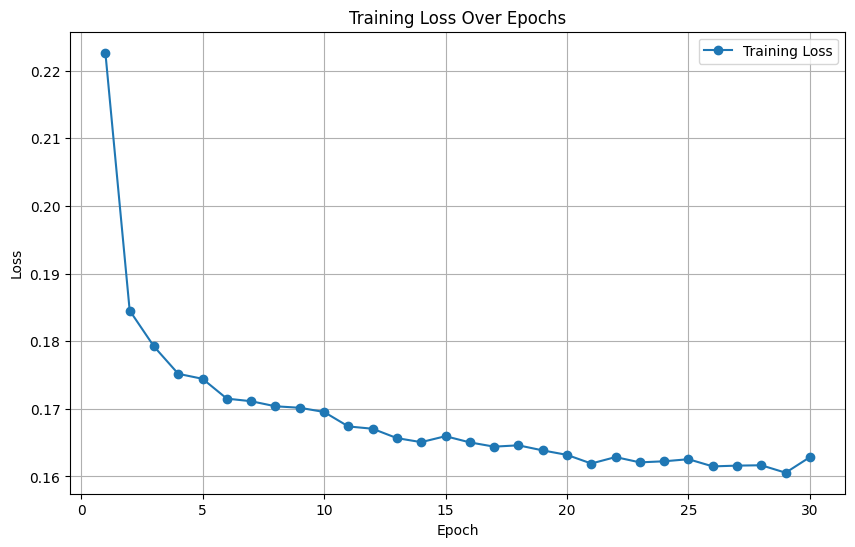

In [38]:
# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', label='Training Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

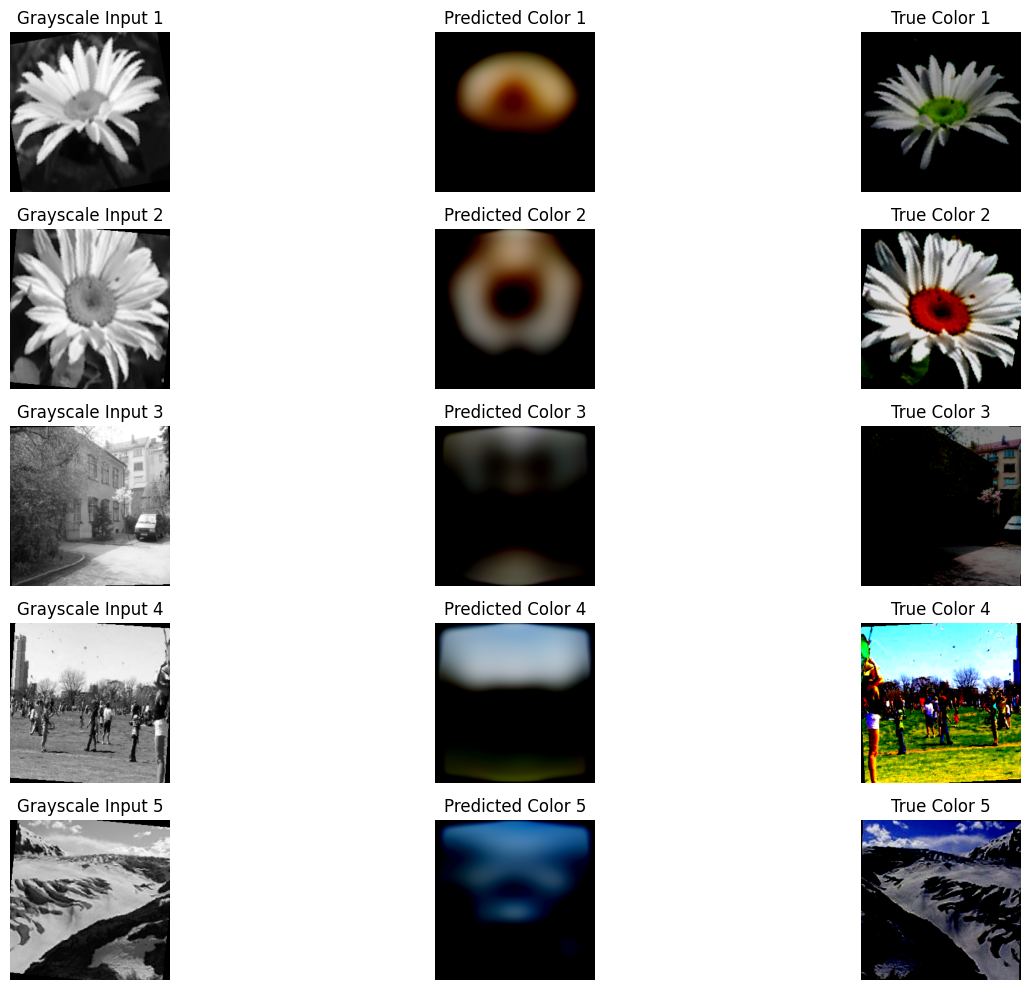

In [39]:
import matplotlib.pyplot as plt

# Test on a single batch
model.eval()
with torch.no_grad():
    for gray_batch, color_batch in test_loader:
        gray_batch = gray_batch.to(device)
        outputs = model(gray_batch)

        # Move to CPU and convert to numpy
        gray_images = gray_batch.cpu().numpy()
        predicted_colors = outputs.cpu().numpy()
        true_colors = color_batch.cpu().numpy()

        # Display first 5 samples in the batch
        num_images = 5  # Number of images to display
        plt.figure(figsize=(15, 10))
        for i in range(num_images):
            # Grayscale Input
            plt.subplot(num_images, 3, i * 3 + 1)
            plt.title(f"Grayscale Input {i+1}")
            plt.imshow(gray_images[i][0], cmap="gray")  # Grayscale image
            plt.axis("off")
            
            # Predicted Color
            plt.subplot(num_images, 3, i * 3 + 2)
            plt.title(f"Predicted Color {i+1}")
            plt.imshow(predicted_colors[i].transpose(1, 2, 0))  # Predicted RGB image
            plt.axis("off")
            
            # True Color
            plt.subplot(num_images, 3, i * 3 + 3)
            plt.title(f"True Color {i+1}")
            plt.imshow(true_colors[i].transpose(1, 2, 0))  # Ground truth RGB image
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        break  # Only process one batch

In [40]:
pip install torchmetrics[image] lpips colormath torch-fidelity scikit-image

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.9 MB/s eta 0:00:00
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39407 sha256=f5e63ee7ade1aa4bb2e9d8c7a2cf38730b819cd27d9299a793bae8f0d86b4272
  Stored in directory: /root/.cache/pip/wheels/ab/b3/4d/c0738759c25a1df01958068f162cf2a9dc3ab1da8b972cfcfc
Successfully built colormath
Note: you may need to restart the kernel to use updated packages.


In [41]:
import torch
import torch.nn.functional as F

def calculate_psnr(predicted, ground_truth):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between predicted and ground-truth images.
    Args:
        predicted (torch.Tensor): Predicted images, shape [B, C, H, W].
        ground_truth (torch.Tensor): Ground-truth images, shape [B, C, H, W].
    Returns:
        float: Average PSNR for the batch.
    """
    mse = F.mse_loss(predicted, ground_truth, reduction='none')  # Per-pixel MSE
    mse_per_image = mse.view(mse.size(0), -1).mean(dim=1)  # Average MSE per image
    psnr_per_image = 10 * torch.log10(1 / mse_per_image)  # Assuming pixel range [0, 1]
    return psnr_per_image.mean().item()

# Loop through the test loader to calculate average PSNR
def evaluate_psnr(model, test_loader, device):
    model.eval()
    total_psnr = 0.0
    num_batches = 0

    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)

            predicted = model(gray_batch)
            psnr = calculate_psnr(predicted, color_batch)
            total_psnr += psnr
            num_batches += 1

    return total_psnr / num_batches

In [42]:
from torchmetrics.image.fid import FrechetInceptionDistance

def evaluate_fid(model, test_loader, device):
    model.eval()
    fid = FrechetInceptionDistance(feature=2048).to(device)

    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)

            predicted = model(gray_batch)
            fid.update(preds=predicted, target=color_batch)

    return fid.compute().item()

In [43]:
import lpips

def evaluate_lpips(model, test_loader, device):
    model.eval()
    lpips_loss = lpips.LPIPS(net='alex').to(device)  # Use AlexNet features
    total_lpips = 0.0
    num_batches = 0

    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)

            predicted = model(gray_batch)
            batch_lpips = lpips_loss(predicted, color_batch)
            total_lpips += batch_lpips.mean().item()
            num_batches += 1

    return total_lpips / num_batches

In [44]:
from skimage.color import deltaE_ciede2000, rgb2lab

def rgb_to_lab(image):
    # Convert RGB to LAB for scikit-image
    image = image.permute(0, 2, 3, 1).cpu().numpy()  # Convert to HWC
    lab_images = [rgb2lab(img) for img in image]  # LAB conversion
    return lab_images

def evaluate_ciede2000(model, test_loader, device):
    model.eval()
    total_ciede2000 = 0.0
    num_pixels = 0

    with torch.no_grad():
        for gray_batch, color_batch in test_loader:
            gray_batch = gray_batch.to(device)
            color_batch = color_batch.to(device)

            predicted = model(gray_batch)
            predicted_lab = rgb_to_lab(predicted)
            true_lab = rgb_to_lab(color_batch)

            for pred_lab, true_lab in zip(predicted_lab, true_lab):
                diff = deltaE_ciede2000(pred_lab, true_lab)  # Calculate CIEDE2000
                total_ciede2000 += diff.sum()
                num_pixels += diff.size

    return total_ciede2000 / num_pixels

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate PSNR
psnr = evaluate_psnr(model, test_loader, device)
print(f"PSNR: {psnr:.2f} dB")


# Calculate LPIPS
lpips_score = evaluate_lpips(model, test_loader, device)
print(f"LPIPS: {lpips_score:.4f}")

# Calculate CIEDE2000
ciede2000 = evaluate_ciede2000(model, test_loader, device)
print(f"CIEDE2000: {ciede2000:.4f}")


PSNR: 8.34 dB
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 200MB/s]  


Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/opt/conda/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

LPIPS: 0.8517
CIEDE2000: 23.3363
